In [1]:
import gc
from models import *
from load import *
from torch import Tensor, nn
import torch
import matplotlib.pyplot as plt
from models_base import Dataset, get_device
from modules import NormalizedPoissonRMSE, PoissonVAEEncoder, PoissonVAEDecoder, PoissonVAE

ROOT = "./Datas/Week 7"

class Progress:
    def __init__(self, pad = 200):
        self.pad = pad
    
    def rint(self, content: str):
        print(content.ljust(self.pad), end = '\r')
        self.pad = max(self.pad, len(content) + 1)

Q = 1.60217663e-19

# Use this with the debugger to create an ad hoc cuda memory watcher in profile txt
class CudaMonitor:
    # Property flag forces things to save everytime a line of code gets run in the debugger
    @property
    def memory(self):
        print("Logging memory")
        s = []
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    # Total numbers
                    total = 1
                    for i in obj.shape:
                        total *= i
                    s.append((total, f"Tensor: {type(obj)}, size: {obj.size()}, shape: {obj.shape}"))
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except Exception as e:
                pass
        s = [x[1] for x in sorted(s, key = lambda a: a[0], reverse = True)]
        with open("profile.txt", 'w') as f:
            f.write(f"Memory allocated: {torch.cuda.memory_allocated()}\n")
            f.write(f"Max memory allocated: {torch.cuda.max_memory_allocated()}\n")
            for y in s:
                f.write(y)
                f.write("\n")
        return "\n".join(s)
    
    def clear(self):
        torch.cuda.empty_cache()
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    del obj
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except Exception as e:
                pass

def init_weights(m):
    try:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    except AttributeError:
        pass

def load():
    ep = Dataset(load_elec_potential())
    sc = Dataset(load_space_charge() * (-Q))
    epsc = (ep + sc).clone().to_tensor().reshape(-1, 4386)
    return epsc

def train(epochs: int):
    noise_ = 0.01
    device = get_device()
    latent = 5
    net = PoissonVAE(PoissonVAEEncoder(latent), PoissonVAEDecoder(latent)).to(device).double()
    net.apply(init_weights)
    history = []
    mse = nn.MSELoss()
    poi = NormalizedPoissonRMSE()
    epsc = load().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    p = Progress()
    c = CudaMonitor()

    for epoch in range(epochs):
        # Add some noise
        def closure():
            # Bring memory watcher in :)
            nonlocal c

            if torch.is_grad_enabled():
                optimizer.zero_grad()

            x = epsc
            noisy_x = x + (torch.rand((1, 4386)) - 1/2).to(device).double() * noise_
            x_hat = net(noisy_x)
            mse_loss_ep = mse(x[:, :2193], x_hat[:, :2193])
            mse_loss_sc = mse(x[:, 2193:], x_hat[:, 2193:])
            poi_loss = poi(x_hat[:, :2193], x_hat[:, 2193:])
            kl_diver = net.encoder.kl
            loss = mse_loss_ep + mse_loss_sc + poi_loss + kl_diver
            if loss.requires_grad:
                loss.backward()

            nonlocal history
            history.append([mse_loss_ep.item(), mse_loss_sc.item(), poi_loss.item(), kl_diver.item()])

            nonlocal p
            mse1_, mse2_, poi_, kl_ = history[-1]
            p.rint(f"Elapsed {epoch} epochs with MSE: {mse1_:.7f}, {mse2_:.7f}, Poisson: {poi_:.7f}, KL divergence: {kl_:.7f}")

            return loss
        optimizer.step(closure)
    return net, history

In [2]:
net, history = train(1000)

ValueError: not enough values to unpack (expected 2, got 1)

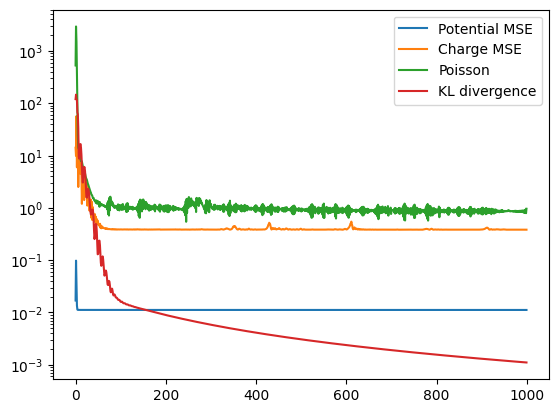

In [ ]:
plt.figure()
plt.plot(history[::])
plt.yscale('log')
plt.legend(["Potential MSE", "Charge MSE", "Poisson", "KL divergence"])
plt.show()

In [ ]:
from torchsummary import summary
summary(net, verbose=0)

Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Linear: 2-1                       4,387,000
|    └─Linear: 2-2                       300,300
|    └─Linear: 2-3                       15,050
|    └─Sigmoid: 2-4                      --
|    └─Linear: 2-5                       255
|    └─Tanh: 2-6                         --
|    └─Linear: 2-7                       255
|    └─Sigmoid: 2-8                      --
├─Decoder: 1-2                           --
|    └─Linear: 2-9                       300
|    └─Sigmoid: 2-10                     --
|    └─Linear: 2-11                      15,300
|    └─Sigmoid: 2-12                     --
|    └─Linear: 2-13                      301,000
|    └─Linear: 2-14                      2,195,193
|    └─Linear: 2-15                      150,500
|    └─Sigmoid: 2-16                     --
|    └─Linear: 2-17                      1,098,693
|    └─Sigmoid: 2-18                     --
Total params: 8,463,846


In [ ]:
# from anim import make_anim
# device = get_device()
# ep = load_elec_potential().cpu().numpy()
# sc = load_space_charge().cpu().numpy() * -Q
# x = load().to(device)
# with torch.no_grad():
#     y = net(x)
#     y_ep = y[:, :2193].reshape(-1, 129, 17).cpu().numpy()
#     y_sc = y[:, 2193:].reshape(-1, 129, 17).cpu().numpy()
#     make_anim(y_ep, ep, "./potential.gif", "Potential")
#     make_anim(y_sc, sc, "./spacecharge.gif", "Space charge")